In [1]:
import h5py
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from IPython.display import clear_output
%matplotlib nbagg
from alvra_tools.psen import *

ModuleNotFoundError: No module named 'alvra_tools.psen'

In [2]:
lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)

filter = np.concatenate((np.ones(50), signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))

background_from_fit = np.loadtxt('/sf/alvra/data/p19198/scratch/2021-06-28-18:02-psen-background.txt')
peakback = np.loadtxt('/sf/alvra/data/p19198/scratch/2021-06-28-18:02-psen-peak-background.txt')

### Run next cell only once to make the directories for the SPECENC files.

In [3]:
path = '/sf/alvra/data/p19198/raw/'

folderlist = []
for file in glob.glob(path + 's375_*'):
    folderlist.append(file)
folderlist = sorted(folderlist)

for folder in folderlist:
    print (folder.split('/')[-1])
    os.mkdir('/sf/alvra/data/p19198/scratch/' + folder.split('/')[-1])


s375_AuCTAB_b


In [15]:
# choose the data file(s):

datafiles = []
for file in glob.glob('/sf/alvra/data/p19198/raw/s375_*/*.BSDATA.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)
datafiles

['/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015278.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015279.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015280.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015281.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015282.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015283.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015284.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015285.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015286.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015287.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015288.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015289.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015290.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015291.BSDATA.h5',
 '/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015292.BSDATA.h5',
 '/sf/alvra/data/p19198/r

In [17]:
datafiles = datafiles[-1]
datafiles

'/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015320.BSDATA.h5'

In [13]:
len(datafiles)

1

In [11]:
print ('check folder name: {}'.format(datafiles[0].split('/')[-2]))

IndexError: list index out of range

In [18]:
px2fs = 2.2054 # new spectrometer, it is ~ 2 px to fs
p0 = 1024

for file in [datafiles]:
    clear_output(wait=True)
    print(file)
    
    with h5py.File(file, 'r') as f:
#        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
        pulse_ids = f['/SARES11-SPEC125-M2.roi_signal_x_profile/pulse_id'][:]
        
        #stage_delay = f['/SLAAR11-LMOT-M453:MOTOR_1.RBV/data'][0]  ## NBS PV, set to delay in fs from Delay Panel
     
        #stage_delay_mm = f['/data/SLAAR11-LMOT-M451:ENC_1_BS/data'][0]    ## Topas Delay in mm.
    #stage_delay = (stage_delay_mm - Timezero)*2/(3e8*1e3*1e-15)           ## convert Delay to fs, if loaded in mm
    
    edgePos = [] # edge positions in fs
    peakAmp = [] # xcorr amplitudes in arb. units
    pids = [] # pulse ids
    
    for k in range(0, len(pulse_ids)):
        pids.append(int(pulse_ids[k]))
        
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)

        sig5gaussO0 = gaussian_filter1d(sig5, 30)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
        
        peak2 = np.argmax(sig5gaussO1)
        
        edgePos.append((p0 - peak2)*px2fs)
        peakAmp.append(np.max(sig5gaussO1) * 11500)
    
    folderName = file.split('/')[-2]
    runNumber = file.split('.')[0].split('/')[-1]
    
    savefile = '/sf/alvra/data/p19198/scratch/' + folderName + '/' + runNumber + '.SPECENC.h5'
          
    hf = h5py.File(savefile, 'w')
    hf.create_dataset('pulse_ids', data=pids)
#    hf.create_dataset('nominal_delay_from_stage', data=stage_delay)
    hf.create_dataset('arrival_times', data=edgePos)
    hf.create_dataset('arrival_times_amplitude', data=peakAmp)
    hf.close()
    print (savefile)

/sf/alvra/data/p19198/raw/s375_AuCTAB_b/run_015320.BSDATA.h5
/sf/alvra/data/p19198/scratch/s375_AuCTAB_b/run_015320.SPECENC.h5


<IPython.core.display.Javascript object>


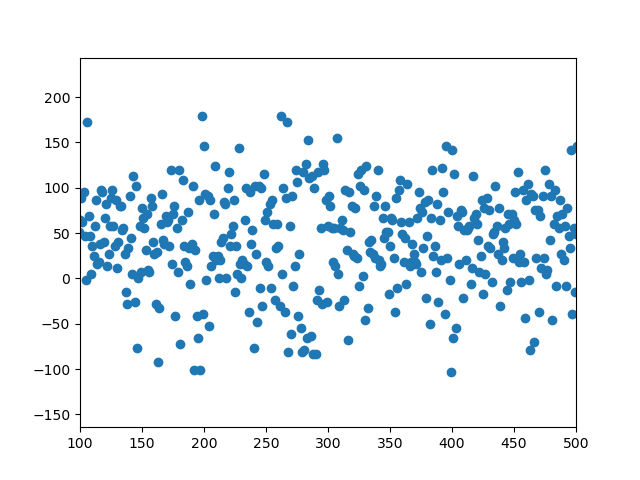

(100, 500)

In [28]:
indexEP = np.asarray(edgePos) < 280
plt.figure()
#plt.plot(peakAmp, 'o')
plt.plot(np.asarray(edgePos)[indexEP], 'o')
plt.xlim(100, 500)

<IPython.core.display.Javascript object>


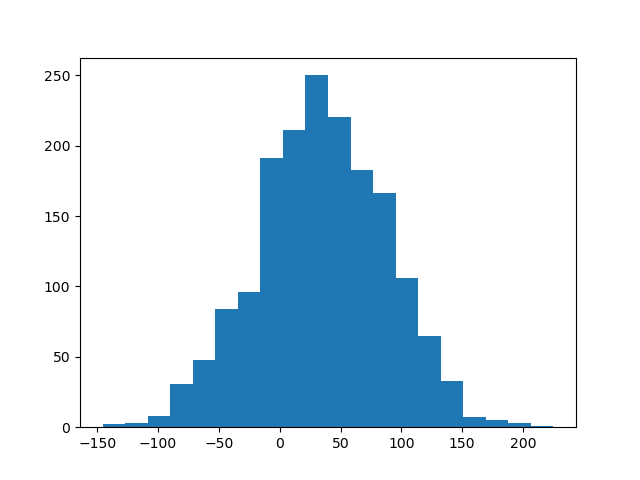

(array([  2.,   3.,   8.,  31.,  48.,  84.,  96., 191., 211., 250., 220.,
        183., 166., 106.,  65.,  33.,   7.,   5.,   3.,   1.]),
 array([-145.5564 , -127.03104, -108.50568,  -89.98032,  -71.45496,
         -52.9296 ,  -34.40424,  -15.87888,    2.64648,   21.17184,
          39.6972 ,   58.22256,   76.74792,   95.27328,  113.79864,
         132.324  ,  150.84936,  169.37472,  187.90008,  206.42544,
         224.9508 ]),
 <a list of 20 Patch objects>)

In [30]:
plt.figure()
plt.hist(np.asarray(edgePos)[indexEP], bins=20)